# **Analysis for Team Assignment 2**

In [1]:
import sys
from pathlib import Path

# Adjust the path below according to your project's structure
# This should be the path to the directory containing 'notebooks' and 'utils'
project_root = Path.cwd().parent  # If your notebook is directly inside the 'notebooks' directory
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils.utility as utility
import imputers.latest_credit_pull_d as lcpd
import imputers.earliest_cr_line_d as ecld
import imputers.last_pymnt_d as lpd
import imputers.numeric_data as nd

# We first import a number of libraries that we will be using in today's class
import pandas as pd
import numpy as np

# Plotting packages we'll use
import matplotlib.pyplot as plt
import seaborn as sns

# Rather than importing the whole sklearn library, we will import only certain modules
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## *Importing Data*

In [4]:
path_to_rejected = '../data/LendingClub/rejected_2007_to_2018Q4.csv'
path_to_accepted = '../data/LendingClub/accepted_2007_to_2018Q4.csv'

## *Read rejected and accpeted data into two seperate dataframes*

In [5]:
# Create DFs
df_rejected = pd.read_csv(path_to_rejected)
df_accepted = pd.read_csv(path_to_accepted)


/var/folders/y4/6g9kvk5j1nl_xnqtxdrs3s180000gn/T/ipykernel_12190/706388349.py:3: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv(path_to_accepted)


In [6]:
# Check rows and columns
print(df_accepted.shape)
print(df_rejected.shape)
# 3. output first 5 observations
#df_rejected.head()
df_accepted.head()

(2260701, 151)
(27648741, 9)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## *Examine features* 

In [ ]:
df_accepted.info(verbose=True, show_counts=True)
df_rejected.info(verbose=True, show_counts=True)


## *Droping columns*

### *Dropping irrelevant columns*

In [7]:
# Get positions of irrelevant columns
rejected_positions_to_drop = [2, 8]
accepted_positions_to_drop = [0, 1, 18, 19, 55, 21, 10, 22]

# Get the column names based on their positions
rejected_columns_to_drop = df_rejected.columns[rejected_positions_to_drop]
accepted_columns_to_drop = df_accepted.columns[accepted_positions_to_drop]

# Drop irrelevant columns
df_rejected = df_rejected.drop(rejected_columns_to_drop, axis=1)
df_accepted = df_accepted.drop(accepted_columns_to_drop, axis=1)


### *Dropping columns with a high null count*

In [8]:
# Drop where the null count is greater than or equal to 50% of samples.
df_accepted = utility.drop_null_columns(df_accepted)
df_rejected = utility.drop_null_columns(df_rejected)

In [ ]:
# Check rows and columns
print(df_accepted.shape)
print(df_rejected.shape)

In [ ]:
print(list(df_accepted.columns))

## Drop outliers

In [9]:
df_accepted = utility.remove_outliers(df=df_accepted)

### Examine data's distribution

In [ ]:
# Get some summary statistics
df_rejected.describe()
df_accepted.describe()

In [10]:
# Get the columns with high skew values as these need to be fixed later
skewed_columns = utility.get_high_skewed_columns(df=df_accepted)
print(skewed_columns)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'fico_range_low', 'fico_range_high', 'open_acc', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'last_fico_range_high', 'last_fico_range_low', 'il_util', 'open_rv_24m', 'acc_open_past_24mths', 'mo_sin_old_rev_tl_op', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m']


In [ ]:
# Visualize numerical data for accepted data
utility.visualize_numerical_variables(df_accepted)

In [ ]:
# Visualize numerical data for rejected data
utility.visualize_numerical_variables(df_rejected)

##  Imputing missing values 

### Imputing dates

In [11]:
# Get a list of all columns that are dates 
potential_date_columns = utility.get_category_columns(df_accepted)

In [ ]:
# Display each object with its value count
value_counts = utility.display_value_counts(df_accepted, potential_date_columns)
value_counts

#### Observations from Value Counts
*Upon looking at the value counts, the following observations were made:*

- There are four dates: 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'
- These values must be properly dealt with to be used in our analysis
- issue_d: 
    - Can not be imputed. Drop all rows where loan_d is null
- earliest_cr_line:
    - Should be imputed based on


In [13]:
# Drop all rows where issue_d is null
df_accepted = df_accepted.dropna(subset=['issue_d'])

In [14]:
# Type cast all date columns to date objects
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
df_accepted = utility.to_datetime(df=df_accepted, columns=date_columns)

In [15]:
# Impute missing dates
ecld_imputer = ecld.EarliestCRLineDateImputer()
ecld_imputer.fit(X=df_accepted)
df_accepted = ecld_imputer.transform(X=df_accepted)

lcpd_imputer = lcpd.LatestCreditPullDateImputer()
lcpd_imputer.fit(X=df_accepted)
df_accepted = lcpd_imputer.transform(X=df_accepted)

lpd_imputer = lpd.LastPaymentDateImputer()
lpd_imputer.fit(X=df_accepted)
df_accepted = lpd_imputer.transform(X=df_accepted)

### Categorical Data

In [16]:
# Drop loan_status: Does not meet the credit policy. Status:Fully Paid, Does not meet the credit policy. Status:Charged Off,
# emp_length: 10+ years, < 1 year
df_accepted = df_accepted[(df_accepted.emp_length != '10+ years') &
                          (df_accepted.emp_length != '< 1 year')]

In [17]:
# Make the rest categorical 
category_columns = utility.get_category_columns(df=df_accepted)
result_list = [item for item in category_columns if item not in date_columns]
df_accepted = utility.to_categorical(df=df_accepted, columns=result_list)

In [18]:
df_accepted.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
8,10000.0,10000.0,10000.0,36 months,6.49,306.45,A,A2,6 years,RENT,...,28.6,1.0,0.0,61099.0,27957.0,16400.0,30799.0,N,Cash,N
11,16000.0,16000.0,16000.0,60 months,12.88,363.07,C,C2,1 year,MORTGAGE,...,60.0,0.0,0.0,309638.0,62407.0,45900.0,45838.0,N,Cash,N
12,1400.0,1400.0,1400.0,36 months,12.88,47.10,C,C2,3 years,MORTGAGE,...,75.0,0.0,0.0,372109.0,75258.0,34500.0,55501.0,N,Cash,N
13,18000.0,18000.0,18000.0,60 months,19.48,471.70,E,E2,7 years,RENT,...,14.3,1.0,0.0,65819.0,36247.0,10300.0,31319.0,N,Cash,N


### Imputing categorical data
- Going to start off with SimpleImputer.
- Change later to more complex and specific imputers.

In [19]:
print(category_columns)

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [ ]:
df_accepted.info(verbose=True, show_counts=True)

In [21]:
# Impute categorical data using mode
imputer = SimpleImputer(strategy='most_frequent')
df_accepted[category_columns] = imputer.fit_transform(df_accepted[category_columns])

### Imputing numerical data
*Lets breakdown each numerical column and make a decision on what imputation strategy would be best:*

- `loan_amnt`: drop. Too important not to have and the number of rows without this amount is small.
- `funded_amnt`: 

In [25]:
print(list(df_accepted.columns))


['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'i

In [28]:
numerical_columns = utility.get_numerical_columns(df_accepted)
columns_for_grouping_and_median = numerical_columns + ['loan_status']
imputer = nd.NumericDataImputer(group_column='loan_status')
imputer.fit(df_accepted[columns_for_grouping_and_median])
df_accepted[columns_for_grouping_and_median] = imputer.transform(df_accepted[columns_for_grouping_and_median])

In [30]:
print(numerical_columns)

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', '

In [ ]:
df_accepted.info(verbose=True, show_counts=True)

In [35]:
# There are still some missing values and that's because some groups had no data for certain columns
df_accepted.groupby('loan_status').describe()

loan_amnt                \
                                                       count          mean   
loan_status                                                                  
Charged Off                                          78289.0  12713.151592   
Current                                             298986.0  13134.104356   
Default                                                 10.0  10775.000000   
Does not meet the credit policy. Status:Charged...      88.0   6992.045455   
Does not meet the credit policy. Status:Fully Paid     291.0   7111.340206   
Fully Paid                                          412203.0  11813.128968   
In Grace Period                                       2319.0  14265.146615   
Late (16-30 days)                                     1246.0  13543.218299   
Late (31-120 days)                                    6159.0  13661.771391   

                                                                             \
                                                       min     25%      50%   
loan_status                                                                   
Charged Off                                          900.0  7550.0  12000.0   
Current                                             1000.0  7225.0  12000.0   
Default                                             4000.0  8100.0   9500.0   
Does not meet the credit policy. Status:Charged...   600.0  2750.0   5250.0   
Does not meet the credit policy. Status:Fully Paid   500.0  3500.0   6000.0   
Fully Paid                                           500.0  6600.0  10000.0   
In Grace Period                                     1000.0  9000.0  13000.0   
Late (16-30 days)                                   1000.0  8000.0  12000.0   
Late (31-120 days)                                  1000.0  8000.0  12000.0   

                                                                      \
                                                        75%      max   
loan_status                                                            
Charged Off                                         16500.0  40000.0   
Current                                             18000.0  40000.0   
Default                                             11737.5  25000.0   
Does not meet the credit policy. Status:Charged...  10000.0  25000.0   
Does not meet the credit policy. Status:Fully Paid  10000.0  25000.0   
Fully Paid                                          16000.0  35000.0   
In Grace Period                                     20000.0  36000.0   
Late (16-30 days)                                   18000.0  40000.0   
Late (31-120 days)                                  19200.0  40000.0   

                                                                funded_amnt  \
                                                            std       count   
loan_status                                                                   
Charged Off                                         6939.976152     78289.0   
Current                                             7518.606230    298986.0   
Default                                             5903.071235        10.0   
Does not meet the credit policy. Status:Charged...  5524.733500        88.0   
Does not meet the credit policy. Status:Fully Paid  4848.159116       291.0   
Fully Paid                                          6565.459704    412203.0   
In Grace Period                                     7379.867943      2319.0   
Late (16-30 days)                                   7568.756268      1246.0   
Late (31-120 days)                                  7355.165324      6159.0   

                                                                  ...  \
                                                            mean  ...   
loan_status                                                       ...   
Charged Off                                         12700.258657  ...   
Current                                             13134.0

In [36]:
# Drop them
df_accepted = df_accepted.dropna()

In [ ]:
df_accepted.info(verbose=True, show_counts=True)

In [38]:
# Save a copy of pre-engineered features
pre_fe_df_accepted = df_accepted.copy(deep=True)

## Feature Engineering

### Feature Engineering Dates Data

In [ ]:
# Feature engineer credit history length and loan age
collection_date = pd.to_datetime('2018-12-31')
df_accepted['credit_history_length'] = (df_accepted['issue_d'] - df_accepted['earliest_cr_line']).dt.days / 365.25
df_accepted['loan_age'] = (df_accepted['last_pymnt_d'] - df_accepted['issue_d']).dt.days / 30
df_accepted['months_since_last_credit_pull'] = (collection_date - df_accepted['last_credit_pull_d']).dt.days / 30

In [47]:
# Drop dates to reduce complexity
df_accepted = df_accepted.drop(date_columns, axis=1)

In [ ]:
df_accepted.info(verbose=True, show_counts=True)

## Examine target variable

In [49]:
df_accepted = utility.calculate_roi(df=df_accepted)

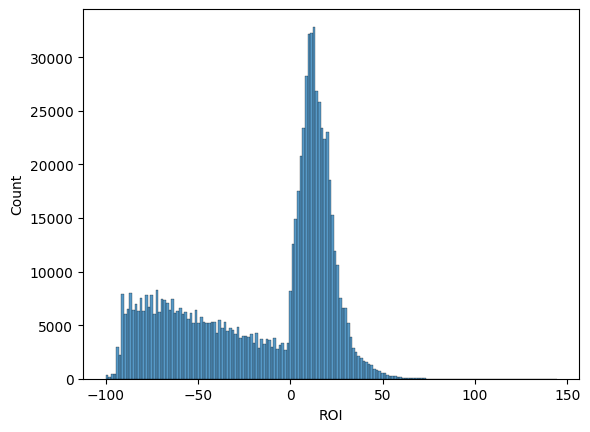

In [52]:
sns.histplot(data=df_accepted, x='ROI')
plt.show()

## Encode Categoroical Data
- one-hot encode the following: term, grade, home_ownerhsip, verification_status, loan_status, pymnt_plan, purpose, initial_list_status, application_type, hardship_flag, disbursement_method, and debt_settlement_flag
- encode addr_state: (one host encoding may not suitable since it will increase dimensionality)

## Standardize Features
##### Ensure our numerical features are standardized (mean of 0 and standard deviation of 1). This is important because Lasso applies the same penalty to all coefficients, so the scale of the features affects which features are selected. Use StandardScalar().

## Apply Lasso Regression
#### Use Lasso regression to fit our model. You may need to tune the regularization parameter (α) using cross-validation to find the optimal value that minimizes your loss function. Libraries like Scikit-learn provide convenient methods like LassoCV for this purpose. This will serve as the baseline (will compare XGBoost and Random Forest performace to this.)

## Evaluate Feature Importance
#### After fitting Lasso, evaluate the coefficients of our model. Features with non-zero coefficients are considered by Lasso as more important for predicting the target variable.

## Model Assessment
#### Assess the performance of our model using appropriate metrics (e.g., R-squared) through cross-validation.

## Implement Random Forest

## Implement XGBoost